# Analytical Parameter Model Optimizer using Tensorflow

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.polynomial.hermite import hermgauss
from __future__ import print_function
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Initialize DataFrame to store data for EDA

In [2]:
tf_parameters = ['step', 'uBA','sbA','uBB','sbB','pA','pb','pc', 'pm','umax','nl',
                 'eLJ','uc','cost']
df_params = pd.DataFrame(columns = tf_parameters)

### Read in Data

In [3]:
bedam_data = pd.read_csv("sampl4-oah-b7eqnosc.repl.cycle.totE.potE.temp.lambda.ebind.dat",delim_whitespace=True, 
                          header=None,names=["replica","cycle","totE",
                                             "potE","temp","Lambda","ebind"])

#ulambda = pandas.read_csv("bcd-nabumetone.repl",delim_whitespace=True, 
#                          header=None,names=["replica","cycle","totE",
#                          "potE","temp","Lambda","ebind"])

In [4]:
bedam_data.dtypes

replica      int64
cycle        int64
totE       float64
potE       float64
temp       float64
Lambda     float64
ebind      float64
dtype: object

In [5]:
kT = 1.986e-3*300.0 # [kcal/mol]
beta = 1/kT
bedam_data['u'] = bedam_data['ebind']*beta
bedam_data.head()

,replica,cycle,totE,potE,temp,Lambda,ebind,u
0,0,0,-367.259,-524.748,300.0,0.0,999984.0,1.678389e+06
1,0,1,-378.435,-536.540,300.0,0.0,980896.0,1.646351e+06
2,0,2,-353.837,-521.889,300.0,0.0,1000000.0,1.678416e+06
3,0,3,-379.433,-544.182,300.0,0.0,999869.0,1.678196e+06
4,0,4,-364.928,-529.571,300.0,0.0,1000000.0,1.678416e+06


In [6]:
bedam_data['mask'] = np.logical_and(bedam_data['Lambda'] > 1.e-6, bedam_data['cycle'] > 100)
bedam_data.tail()

,replica,cycle,totE,potE,temp,Lambda,ebind,u,mask
13866,0,677,-366.430,-540.402,300.0,0.17,-1.37125,-2.301527,True
13867,0,678,-341.743,-518.847,300.0,0.17,-6.76658,-11.357133,True
13868,0,679,-353.513,-516.050,300.0,0.17,-5.37036,-9.013696,True
13869,0,680,-370.622,-537.734,300.0,0.17,-8.18494,-13.737731,True
13870,0,681,-346.630,-518.005,300.0,0.17,3.54029,5.942078,True


In [7]:
rel_data = bedam_data.loc[bedam_data['mask'] == True]
rel_data.head()

,replica,cycle,totE,potE,temp,Lambda,ebind,u,mask
101,0,101,-362.832,-519.400,300.0,0.04,4.28490,7.191843,True
102,0,102,-395.961,-542.808,300.0,0.04,10.12730,16.997818,True
103,0,103,-383.817,-560.799,300.0,0.04,16.06630,26.965928,True
104,0,104,-357.445,-524.409,300.0,0.04,-7.81857,-13.122810,True
105,0,105,-342.067,-508.659,300.0,0.04,14.35490,24.093488,True


In [8]:
rel_data['u'] = rel_data['u'].astype(np.float32)
rel_data['Lambda'] = rel_data['Lambda'].astype(np.float32)
rel_data['U'] = rel_data['u']-1.e6*beta # u-umax
rel_data.dtypes

/Users/dkilburg/pyvenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/dkilburg/pyvenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dkilburg/pyvenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

replica      int64
cycle        int64
totE       float64
potE       float64
temp       float64
Lambda     float32
ebind      float64
u          float32
mask          bool
U          float32
dtype: object

### Initialize parameters

parameters that are being optimized are stored in a `tf.Variable`, those that are kept constant are stored as `tf.constant`

In [9]:
pb = 1.18e-4
pc = 3.00e-2
uc = 0.5
params = {'UBA':tf.constant(-13.953*beta),
          'SIGBA':tf.constant(1.906*beta),
          'UBB':tf.constant(-2.334*beta),
          'SIGBB':tf.constant(3.238*beta),
          'PA':tf.constant(2.45e-4),
          'E':tf.constant(20.0*beta),
          'UC':tf.constant(uc*beta),
          'NL':tf.Variable(2.96),
          'PB':tf.Variable(pb),
          'PC':tf.Variable(pc)}

pi = tf.constant(np.pi, dtype=tf.float32)

### Get variables and weights for Hermite-Gauss Approximation

Here we use 15 Hermite-Gauss nodes. They are placed symmetrically around zero. The 7 negative nodes are not used.

In [10]:
x_gauss,w_gauss = hermgauss(15)
n_gauss = tf.constant(x_gauss.size, dtype=tf.int32)
x_gauss = tf.constant(x_gauss, dtype=tf.float32)
w_gauss = tf.constant(w_gauss, dtype=tf.float32)

### Load (u,lambda) data pairs in constant tensors


In [11]:
u = tf.constant(rel_data['u'])
lambdas = tf.constant(rel_data['Lambda'])


## Definition of Likelihood function in TensorFlow

The negative of the log-likelihood function is:

$-\mathcal{\ln L}(\theta)=-\sum_{i}\ln p_{\lambda_{i}}(u_{i}|\theta)=-\sum_{i}\ln [ e^{-\lambda_{i}u_{i}} p_{0}(u_{i}|\theta)/K(\lambda_{i}|\theta) ]$

where $\theta$ represents the parameters,

$p_{0}(u)=p_{b}p_B(u) + p_{m}p_M(u)+p_{{\rm c}}\int_{\tilde{u}_{C}}^{+\infty}p_{WCA}(u')p_B(u-u')u'$

$K(\lambda)=K_{C}(\lambda)K_{B}(\lambda)$

$K_{C}(\lambda)= p_{b}+p_{m}e^{-\lambda u_{{\rm max}}}+p_{c}K_{WCA}(\lambda)$

$K{}_{WCA}(\lambda)=\int_{\tilde{u}_{C}}^{u_{{\rm max}}}p_{WCA}(u)e^{-\lambda u}du$

$K_{B}(\lambda)=\int_{-\infty}^{+\infty}p_{B}(u)e^{-\lambda u}=e^{\sigma_{B}^{2}\lambda(\lambda/2-\bar{u}_{B}/\sigma_{B}^{2})}$



### Gaussian mixture for B for all binding energies

This computes $p_B(u)$ for all binding energy samples. In general $p_B(u)$ is a mixture of two (or more) Gaussians.

gauss_bA = $\frac{1}{\sqrt{2\pi}\sigma_{BA}}e^{\frac{-(u-u_{BA})^2}{2\sigma_{BA}^2}}$ 
<br>
gauss_bB = $\frac{1}{\sqrt{2\pi}\sigma_{BB}}e^{\frac{-(u-u_{BB})^2}{2\sigma_{BB}^2}}$ 
<br>
gauss_b = $P_A *\frac{1}{\sqrt{2\pi}\sigma_{BA}}e^{\frac{-(u-u_{BA})^2}{2\sigma_{BA}^2}} + (1-P_A)*\frac{1}{\sqrt{2\pi}\sigma_{BB}}e^{\frac{-(u-u_{BB})^2}{2\sigma_{BB}^2}}$

where $P_A$ and $P_B = 1 - P_A$ are the populations of the two conformational states at $\lambda = 0$

In [12]:
gauss_bA = tf.exp(-tf.pow(u-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gauss_bB = tf.exp(-tf.pow(u-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gauss_b = params['PA']*gauss_bA + gauss_bB - params['PA']*gauss_bB

### Gaussian for energies at large distances where U -> u-umax where umax = $10^6/kT$

this computes $p_M(u)$, which has the same form and parameters of $p_B(u)$ but is centered at $\bar{u}_B + u_{\rm max}$ 

gauss_bA_far = $\frac{1}{\sqrt{2\pi}\sigma_{BA}}e^{\frac{-(U-u_{BA})^2}{2\sigma_{BA}^2}}$ 
<br>
gauss_bB_far = $\frac{1}{\sqrt{2\pi}\sigma_{BB}}e^{\frac{-(U-u_{BB})^2}{2\sigma_{BB}^2}}$ 
<br>
gauss_b_far = $P_A *\frac{1}{\sqrt{2\pi}\sigma_{BA}}e^{\frac{-(U-u_{BA})^2}{2\sigma_{BA}^2}} + (1-P_A)*\frac{1}{\sqrt{2\pi}\sigma_{BB}}e^{\frac{-(U-u_{BB})^2}{2\sigma_{BB}^2}}$

U is $u - u_{\rm max}$ so the argument of each Gaussian is $u - (u_{\rm max} +  \bar{u}_B)$.

In [13]:
U = tf.constant(rel_data['U'])

gauss_bA_far = tf.exp(-tf.pow(U-params['UBA'],2)/(2.0*tf.pow(params['SIGBA'],2)))/(tf.sqrt(2.*pi)*params['SIGBA'])
gauss_bB_far = tf.exp(-tf.pow(U-params['UBB'],2)/(2.0*tf.pow(params['SIGBB'],2)))/(tf.sqrt(2.*pi)*params['SIGBB'])
gauss_b_far = params['PA']*gauss_bA_far + gauss_bB_far - params['PA']*gauss_bB_far


### Convolution of gaussian (mixture) and pwca

pwca = $n_L * \left[1-\frac{\sqrt{1+\hat{x}_c}}{\sqrt{1+x}} \right]^{n_L-1}*\frac{Heaviside(u_c-\hat{u}_c)\sqrt{1+\hat{x}_c}}{4\epsilon_{LJ}x(1+x)^{3/2}}$ <br>
where <br>
$x = \sqrt{u_c/\epsilon_{LJ}}$ <br>
$\hat{x}_c = \sqrt{\hat{u}_c/\epsilon_{LJ}}$

#### Assuming statistical independence of the background and collisional energies, the probability density of the total binding energy is given by $P_0$ which is the convolution of their respective probability densities

$p_0(u) = p_b p_B(u) + p_m p_M(u) + p_c \int_{u_c}^\infty p_{wca}(u')p_B(u-u')du'$

`nm` is an approximation such that to the normalization factor of $p_{wca}$ between $u_C$ and $u_{\rm max}$ is ${\rm nm} \times nl$ 

In [14]:
umax = 1.e6*beta
pm = tf.constant(1. - pb - pc)
xc = tf.sqrt(params['UC']/params['E'])
a = tf.sqrt(1.+xc)
eps = xc/10.
xm = tf.sqrt(umax/params['E'])
nm = tf.pow(1. - params['NL']*a/xm, -1)


this performs the convolution. Once for each of the two states (A and B) of the mixture in $p_B(u)$

In [15]:
sq2 = tf.sqrt(2.)
#Pwca for all input y's
yA = sq2*params['SIGBA']*x_gauss + u[:,None] - params['UBA']
x1A = tf.pow(yA/params['E'],2) #to make x positive
xA  = tf.pow( x1A , 0.25 )
bA = tf.sqrt(1.+ xA)
z1A = tf.tanh( tf.pow(a/bA,12.) )
zA = tf.pow( z1A, 1./12. ) #caps z to 1
fcore2A = tf.pow((1.-zA), params['NL']-1.)
fcore3A = a/((xA+eps)*tf.pow(bA,3)*4.*params['E'])
fcore4A = tf.sigmoid(20.*(yA-0.5*params['UC'])/params['UC'])
pwcaA = nm*params['NL']*fcore2A*fcore3A*fcore4A
#---
qA = tf.matmul(pwcaA,tf.reshape(w_gauss,[n_gauss,1]))/tf.sqrt(pi)
q2A = qA[:,0]

yB = sq2*params['SIGBB']*x_gauss + u[:,None] - params['UBB']
x1B = tf.pow(yB/params['E'],2) #to make x positive
xB  = tf.pow( x1B , 0.25 )
bB = tf.sqrt(1.+ xB)
z1B = tf.tanh( tf.pow(a/bB,12.) )
zB = tf.pow( z1B, 1./12. ) #caps z to 1
fcore2B = tf.pow((1.-zB), params['NL']-1.)
fcore3B = a/((xB+eps)*tf.pow(bB,3)*4.*params['E'])
fcore4B = tf.sigmoid(20.*(yB-0.5*params['UC'])/params['UC'])
pwcaB = nm*params['NL']*fcore2B*fcore3B*fcore4B
#---
qB = tf.matmul(pwcaB,tf.reshape(w_gauss,[n_gauss,1]))/tf.sqrt(pi)
q2B = qB[:,0]

q2 = params['PA']*q2A + q2B - params['PA']*q2B

#p0's
p0 = params['PB']*gauss_b + params['PC']*q2 + pm*gauss_b_far



### Model for the free energy profile

this is $K_{B}(\lambda)=\int_{-\infty}^{+\infty}p_{B}(u)e^{-\lambda u}=e^{\sigma_{B}^{2}\lambda(\lambda/2-\bar{u}_{B}/\sigma_{B}^{2})}$ but for the state mixture

In [16]:
#kB1
klBA = tf.exp(0.5*tf.pow(params['SIGBA'],2)*tf.pow(lambdas,2) - lambdas*params['UBA'])
klBB = tf.exp(0.5*tf.pow(params['SIGBB'],2)*tf.pow(lambdas,2) - lambdas*params['UBB']) 
klB1 = params['PA']*klBA + klBB - params['PA']*klBB



this sets up an exponential grid to perform

$K{}_{WCA}(\lambda)=\int_{\tilde{u}_{C}}^{u_{{\rm max}}}p_{WCA}(u)e^{-\lambda u}du$

`xasymp` is the actual grid ($x$), `dxasymp` is the grid spacing ($dx$)

In [17]:
a = uc*beta
umax = 1.e6*beta
ymax = np.log(umax)/a # 
dy = ymax/100.0
xasymp = np.float32(np.exp(a*np.arange(0.,ymax,dy)) - 1.) + 1.e-6
dxasymp = np.float32(xasymp[1:] - xasymp[:-1])
xasymp = np.float32(xasymp[:-1])

nx = tf.constant(dxasymp.size, dtype=tf.int32)
xasymp = tf.constant(xasymp, dtype=tf.float32)
dxasymp = tf.constant(dxasymp, dtype=tf.float32)


this computes a modified $p_{wca}(u)$ over the integration grid to avoid the step function:

$p_{WCA}(u_{C})\simeq n_{l}\left[1-\tanh(z^{12})^{1/12}\right]^{n_{l}-1}\frac{s(u_{C}-\tilde{u}_{C})}{4\epsilon_{LJ}}\frac{(1+x_{C})^{1/2}}{x(1+x)^{3/2}}$

where $z=(1+x_{C})^{1/2}/(1+x)^{1/2}$ and $s(u)=[1+\exp(-20u/\tilde{u}_{C})]^{-1}$ is the sigmoid function.

It then perform the integration for all possible $\lambda$ values by computing a 2-D $\exp(-\lambda u)$ tensor and performing a matrix multiplication.

In [18]:

#pwca for the x grid
x1_s = tf.pow(xasymp/params['E'],2) #to make x positive
x_s  = tf.pow( x1_s , 0.25 )
b_s = tf.sqrt(1.+ x_s)
z1_s = tf.tanh( tf.pow(a/b_s,12.) )
z_s = tf.pow( z1_s, 1./12. ) #caps z to 1
fcore2_s = tf.pow((1.-z_s), params['NL']-1.)
fcore3_s = a/((x_s+eps)*tf.pow(b_s,3)*4.*params['E'])
fcore4_s = tf.sigmoid(20.*(xasymp-0.5*params['UC'])/params['UC'])
pwca_s = nm*params['NL']*fcore2_s*fcore3_s*fcore4_s

#kwca
fsamples = dxasymp*pwca_s
expl = tf.exp(- xasymp * lambdas[:,None])
q_C = tf.matmul(expl,tf.reshape(fsamples,[nx,1]))
klwca = q_C[:,0]


Finally it assembles $p_0(u)$ and $K(\lambda)$ for each data point into the -log likelihood.

In [19]:
#free energies
e2 = tf.exp(-1.e6*beta * lambdas)
klC = params['PB'] + e2 - params['PC']*e2 - params['PB']*e2 + params['PC'] * klwca
kl = klB1*klC
pkl = p0/kl

#cost function
cost = -tf.reduce_sum(tf.log(pkl))

### Initialize and start tensorflow optimizer session

In [20]:
optimizer = tf.train.AdamOptimizer(2.e-4)

train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

gradient_cost = optimizer.compute_gradients(cost)


with tf.Session() as sess:
    
    sess.run(init)
    ll = sess.run(cost)

    best_loss = ll
    best_ubA = sess.run(params['UBA'])
    best_sbA = sess.run(params['SIGBA'])
    best_ubB = sess.run(params['UBB'])
    best_sbB = sess.run(params['SIGBB'])
    best_pA = sess.run(params['PA'])
    best_pb = sess.run(params['PB'])
    best_pc = sess.run(params['PC'])
    best_nl = sess.run(params['NL'])
    best_elj = sess.run(params['E'])
    best_uc = sess.run(params['UC'])   
    for step in range(100):
        sess.run(train)
        ll = sess.run(cost)
        lubA = sess.run(params['UBA'])
        lsbA = sess.run(params['SIGBA'])
        lubB = sess.run(params['UBB'])
        lsbB = sess.run(params['SIGBB'])
        lpA =  sess.run(params['PA'])
        lpb = sess.run(params['PB'])
        lpc = sess.run(params['PC'])
        lnl = sess.run(params['NL'])
        lelj = sess.run(params['E'])
        luc = sess.run(params['UC'])                     
        if( ll < best_loss ):
            best_loss = ll
            best_ubA = lubA
            best_sbA = lsbA
            best_ubB = lubB
            best_sbB = lsbB
            best_pA = lpA
            best_pb = lpb
            best_pc = lpc
            best_nl = lnl
            best_elj = lelj
            best_uc = luc
      
        df_params = df_params.append({'step':step,'uBA':lubA*kT,'sbA':lsbA*kT,
                                           'uBB':lubB*kT,'sbB':lsbB*kT,'pA':lpA,'pb':lpb,
                                           'pc':lpc,'pm':1.0-pb-pc,'umax':umax,'nl':lnl,'eLJ':lelj*kT,
                                           'uc':luc*kT,'cost':ll},ignore_index=True)

    print("----- End of optimization --------");
    print("best", "x:", " uBA =", best_ubA*kT, "sbA =", best_sbA*kT, "uBB =", best_ubB*kT, "sbB =", best_sbB*kT, "pA =", best_pA, "pb = ", best_pb, "pc =", best_pc, "pm = ", 1.0-pb-pc, "umax = ", umax, "nl = ", best_nl, "eLJ = ", best_elj*kT, "uc = ", best_uc*kT, "cost =", best_loss)



----- End of optimization --------
best x:  uBA = -13.952999662399291 sbA = 1.90600006814003 uBB = -2.3340000610828397 sbB = 3.2379999492645264 pA = 0.000245 pb =  0.0013305743 pc = 0.031768613 pm =  0.969882 umax =  1678415.5756965424 nl =  2.9426587 eLJ =  19.9999989692688 uc =  0.4999999884366989 cost = 133303.48


In [21]:
df_params.head()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
0,0.0,-13.953,1.906,-2.334,3.238,0.000245,0.000318,0.029800,0.969882,1.678416e+06,2.960200,19.999999,0.5,134656.015625
1,1.0,-13.953,1.906,-2.334,3.238,0.000245,0.000482,0.029607,0.969882,1.678416e+06,2.960380,19.999999,0.5,133960.125000
2,2.0,-13.953,1.906,-2.334,3.238,0.000245,0.000622,0.029423,0.969882,1.678416e+06,2.960524,19.999999,0.5,133655.687500
3,3.0,-13.953,1.906,-2.334,3.238,0.000245,0.000743,0.029247,0.969882,1.678416e+06,2.960620,19.999999,0.5,133499.218750
4,4.0,-13.953,1.906,-2.334,3.238,0.000245,0.000849,0.029082,0.969882,1.678416e+06,2.960664,19.999999,0.5,133413.015625


In [22]:
df_params.tail()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
95,95.0,-13.953,1.906,-2.334,3.238,0.000245,0.001326,0.031798,0.969882,1.678416e+06,2.943379,19.999999,0.5,133304.203125
96,96.0,-13.953,1.906,-2.334,3.238,0.000245,0.001327,0.031791,0.969882,1.678416e+06,2.943199,19.999999,0.5,133304.031250
97,97.0,-13.953,1.906,-2.334,3.238,0.000245,0.001328,0.031783,0.969882,1.678416e+06,2.943019,19.999999,0.5,133303.843750
98,98.0,-13.953,1.906,-2.334,3.238,0.000245,0.001329,0.031776,0.969882,1.678416e+06,2.942839,19.999999,0.5,133303.671875
99,99.0,-13.953,1.906,-2.334,3.238,0.000245,0.001331,0.031769,0.969882,1.678416e+06,2.942659,19.999999,0.5,133303.484375


In [23]:
df_params.describe()

,step,uBA,sbA,uBB,sbB,pA,pb,pc,pm,umax,nl,eLJ,uc,cost
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,1.000000e+02,100.000000
mean,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001375,0.030222,9.698820e-01,1.678416e+06,2.952093,19.999999,5.000000e-01,133356.501406
std,29.011492,5.355917e-15,2.231632e-16,4.463264e-16,4.463264e-16,0.000000,0.000225,0.001468,1.115816e-16,4.680072e-10,0.005697,0.000000,5.579081e-17,152.433596
min,0.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.000318,0.027992,9.698820e-01,1.678416e+06,2.942659,19.999999,5.000000e-01,133303.484375
25%,24.750000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001322,0.028761,9.698820e-01,1.678416e+06,2.947116,19.999999,5.000000e-01,133307.535156
50%,49.500000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001371,0.030496,9.698820e-01,1.678416e+06,2.951918,19.999999,5.000000e-01,133321.156250
75%,74.250000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001529,0.031770,9.698820e-01,1.678416e+06,2.957273,19.999999,5.000000e-01,133362.312500
max,99.000000,-1.395300e+01,1.906000e+00,-2.334000e+00,3.238000e+00,0.000245,0.001615,0.031849,9.698820e-01,1.678416e+06,2.960664,19.999999,5.000000e-01,134656.015625


In [24]:
df_cost = df_params[['step','cost']]
df_cost.tail()

,step,cost
95,95.0,133304.203125
96,96.0,133304.031250
97,97.0,133303.843750
98,98.0,133303.671875
99,99.0,133303.484375


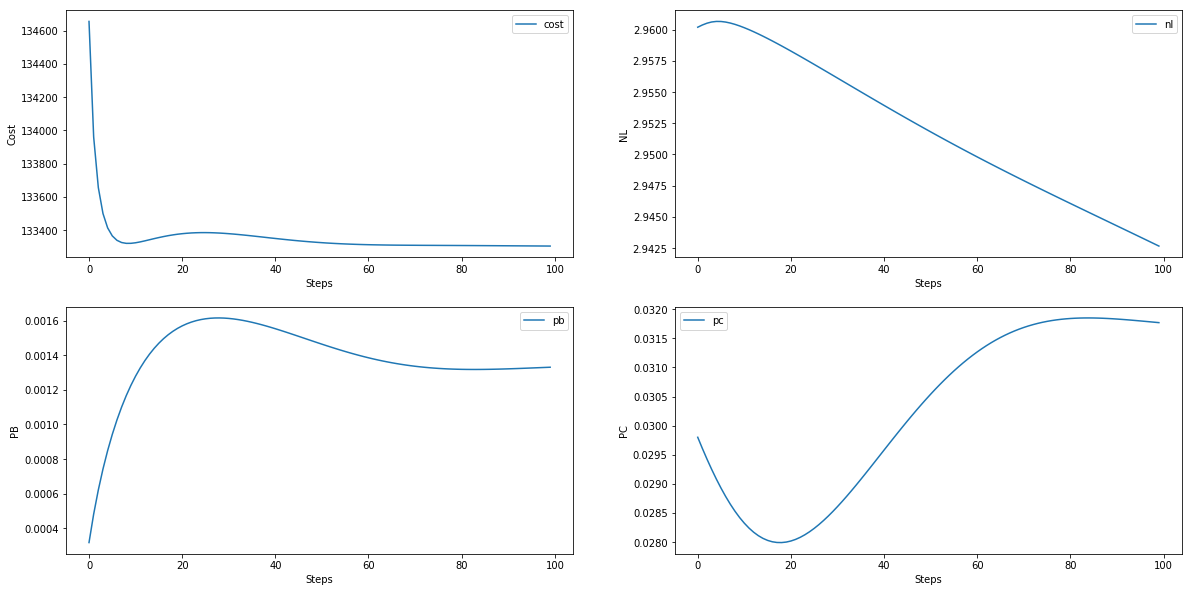

In [25]:
fig = plt.figure()

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

# 1st plot
df_params.plot(kind='line',x='step',y='cost', figsize=(20,10),ax=ax0)
ax0.set_ylabel("Cost")
ax0.set_xlabel("Steps")

# 2nd plot
df_params.plot(kind='line',x='step',y='nl',figsize=(20,10),ax=ax1)
ax1.set_ylabel("NL")
ax1.set_xlabel("Steps")

# 3rd plot
df_params.plot(kind='line',x='step',y='pb',figsize=(20,10),ax=ax2)
ax2.set_ylabel("PB")
ax2.set_xlabel("Steps")

# 4th plot
df_params.plot(kind='line',x='step',y='pc',figsize=(20,10),ax=ax3)
ax3.set_ylabel("PC")
ax3.set_xlabel("Steps")

plt.show()

In [26]:
tf_parameters = ['step', 'uBA','sbA','uBB','sbB','pA','pb','pc', 'pm','umax','nl',
                 'eLJ','uc','cost']
df_params = pd.DataFrame(columns = tf_parameters)

optimizer = tf.train.AdamOptimizer(2.e-4)

train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

gradient_cost = optimizer.compute_gradients(cost)


with tf.Session() as sess:
    
    sess.run(init)
    ll = sess.run(cost)

    best_loss = ll
    best_ubA = sess.run(params['UBA'])
    best_sbA = sess.run(params['SIGBA'])
    best_ubB = sess.run(params['UBB'])
    best_sbB = sess.run(params['SIGBB'])
    best_pA = sess.run(params['PA'])
    best_pb = sess.run(params['PB'])
    best_pc = sess.run(params['PC'])
    best_nl = sess.run(params['NL'])
    best_elj = sess.run(params['E'])
    best_uc = sess.run(params['UC'])   
    for step in range(200):
        sess.run(train)
        ll = sess.run(cost)
        lubA = sess.run(params['UBA'])
        lsbA = sess.run(params['SIGBA'])
        lubB = sess.run(params['UBB'])
        lsbB = sess.run(params['SIGBB'])
        lpA =  sess.run(params['PA'])
        lpb = sess.run(params['PB'])
        lpc = sess.run(params['PC'])
        lnl = sess.run(params['NL'])
        lelj = sess.run(params['E'])
        luc = sess.run(params['UC'])                     
        if( ll < best_loss ):
            best_loss = ll
            best_ubA = lubA
            best_sbA = lsbA
            best_ubB = lubB
            best_sbB = lsbB
            best_pA = lpA
            best_pb = lpb
            best_pc = lpc
            best_nl = lnl
            best_elj = lelj
            best_uc = luc
      
        df_params = df_params.append({'step':step,'uBA':lubA*kT,'sbA':lsbA*kT,
                                           'uBB':lubB*kT,'sbB':lsbB*kT,'pA':lpA,'pb':lpb,
                                           'pc':lpc,'pm':1.0-pb-pc,'umax':umax,'nl':lnl,'eLJ':lelj*kT,
                                           'uc':luc*kT,'cost':ll},ignore_index=True)

    print("----- End of optimization --------");
    print("best", "x:", " uBA =", best_ubA*kT, "sbA =", best_sbA*kT, "uBB =", best_ubB*kT, "sbB =", best_sbB*kT, "pA =", best_pA, "pb = ", best_pb, "pc =", best_pc, "pm = ", 1.0-pb-pc, "umax = ", umax, "nl = ", best_nl, "eLJ = ", best_elj*kT, "uc = ", best_uc*kT, "cost =", best_loss)



----- End of optimization --------
best x:  uBA = -13.952999662399291 sbA = 1.90600006814003 uBB = -2.3340000610828397 sbB = 3.2379999492645264 pA = 0.000245 pb =  0.0013536949 pc = 0.031606857 pm =  0.969882 umax =  1678415.5756965424 nl =  2.923915 eLJ =  19.9999989692688 uc =  0.4999999884366989 cost = 133286.61


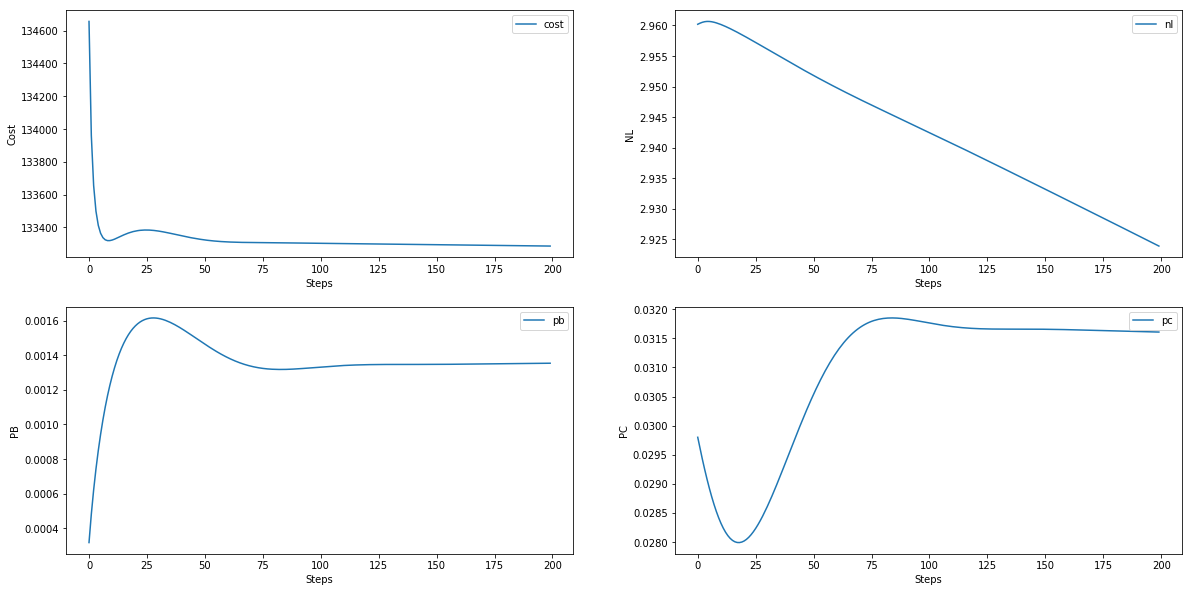

In [27]:
fig = plt.figure()

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

# 1st plot
df_params.plot(kind='line',x='step',y='cost', figsize=(20,10),ax=ax0)
ax0.set_ylabel("Cost")
ax0.set_xlabel("Steps")

# 2nd plot
df_params.plot(kind='line',x='step',y='nl',figsize=(20,10),ax=ax1)
ax1.set_ylabel("NL")
ax1.set_xlabel("Steps")

# 3rd plot
df_params.plot(kind='line',x='step',y='pb',figsize=(20,10),ax=ax2)
ax2.set_ylabel("PB")
ax2.set_xlabel("Steps")

# 4th plot
df_params.plot(kind='line',x='step',y='pc',figsize=(20,10),ax=ax3)
ax3.set_ylabel("PC")
ax3.set_xlabel("Steps")

plt.show()

In [64]:
tf_parameters = ['step', 'uBA','sbA','uBB','sbB','pA','pb','pc', 'pm','umax','nl',
                 'eLJ','uc','cost']
df_params = pd.DataFrame(columns = tf_parameters)

var_list1 = [params['PC'],params['PB'],params['NL']]


## .minimize combines compute_gradients and apply_gradients

opt = tf.train.AdamOptimizer(learning_rate=2.e-4)
grads_and_vars = opt.compute_gradients(cost, var_list=var_list1)
nl_grad,_ = grads_and_vars[2]
train_op = opt.apply_gradients([grads_and_vars[0],grads_and_vars[1],(nl_grad*2.e5,params['NL'])])
######

#optimizer = tf.train.AdamOptimizer(2.e-4)
#train = optimizer.minimize(cost, var_list=var_list1)

init = tf.global_variables_initializer()

#gradient_cost = optimizer.compute_gradients(cost)


with tf.Session() as sess:
    
    sess.run(init)
    ll = sess.run(cost)

    best_loss = ll
    best_ubA = sess.run(params['UBA'])
    best_sbA = sess.run(params['SIGBA'])
    best_ubB = sess.run(params['UBB'])
    best_sbB = sess.run(params['SIGBB'])
    best_pA = sess.run(params['PA'])
    best_pb = sess.run(params['PB'])
    best_pc = sess.run(params['PC'])
    best_nl = sess.run(params['NL'])
    best_elj = sess.run(params['E'])
    best_uc = sess.run(params['UC'])   
    for step in range(300):
        sess.run(train_op)
        ll = sess.run(cost)
        lubA = sess.run(params['UBA'])
        lsbA = sess.run(params['SIGBA'])
        lubB = sess.run(params['UBB'])
        lsbB = sess.run(params['SIGBB'])
        lpA =  sess.run(params['PA'])
        lpb = sess.run(params['PB'])
        lpc = sess.run(params['PC'])
        lnl = sess.run(params['NL'])
        lelj = sess.run(params['E'])
        luc = sess.run(params['UC'])                     
        if( ll < best_loss ):
            best_loss = ll
            best_ubA = lubA
            best_sbA = lsbA
            best_ubB = lubB
            best_sbB = lsbB
            best_pA = lpA
            best_pb = lpb
            best_pc = lpc
            best_nl = lnl
            best_elj = lelj
            best_uc = luc
      
        df_params = df_params.append({'step':step,'uBA':lubA*kT,'sbA':lsbA*kT,
                                           'uBB':lubB*kT,'sbB':lsbB*kT,'pA':lpA,'pb':lpb,
                                           'pc':lpc,'pm':1.0-pb-pc,'umax':umax,'nl':lnl,'eLJ':lelj*kT,
                                           'uc':luc*kT,'cost':ll},ignore_index=True)

    print("----- End of optimization --------");
    print("best", "x:", " uBA =", best_ubA*kT, "sbA =", best_sbA*kT, "uBB =", best_ubB*kT, "sbB =", best_sbB*kT, "pA =", best_pA, "pb = ", best_pb, "pc =", best_pc, "pm = ", 1.0-pb-pc, "umax = ", umax, "nl = ", best_nl, "eLJ = ", best_elj*kT, "uc = ", best_uc*kT, "cost =", best_loss)




----- End of optimization --------
best x:  uBA = -13.952999662399291 sbA = 1.90600006814003 uBB = -2.3340000610828397 sbB = 3.2379999492645264 pA = 0.000245 pb =  0.0013670549 pc = 0.03151003 pm =  0.969882 umax =  1678415.5756965424 nl =  2.904656 eLJ =  19.9999989692688 uc =  0.4999999884366989 cost = 133269.31


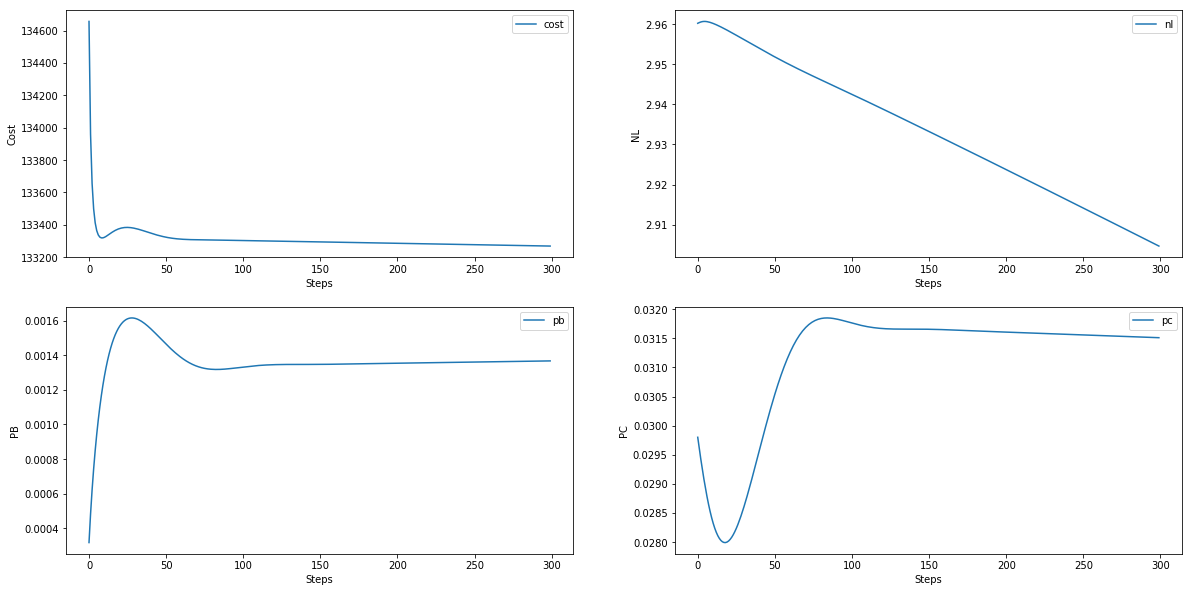

In [65]:
fig = plt.figure()

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

# 1st plot
df_params.plot(kind='line',x='step',y='cost', figsize=(20,10),ax=ax0)
ax0.set_ylabel("Cost")
ax0.set_xlabel("Steps")

# 2nd plot
df_params.plot(kind='line',x='step',y='nl',figsize=(20,10),ax=ax1)
ax1.set_ylabel("NL")
ax1.set_xlabel("Steps")

# 3rd plot
df_params.plot(kind='line',x='step',y='pb',figsize=(20,10),ax=ax2)
ax2.set_ylabel("PB")
ax2.set_xlabel("Steps")

# 4th plot
df_params.plot(kind='line',x='step',y='pc',figsize=(20,10),ax=ax3)
ax3.set_ylabel("PC")
ax3.set_xlabel("Steps")

plt.show()